In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO


In [21]:
# Load YOLOv8 nano model (lightweight, fast)
model = YOLO("yolov8n.pt")  

# Print available classes
print(model.names)


{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [22]:
# Load image
img_path = "sample7.png"   # change to your test image
img = cv2.imread(img_path)

# Run detection
results = model(img)

# Show detected image using YOLO’s built-in plot
results[0].show()



0: 640x640 3 persons, 6 cars, 1 motorcycle, 7 traffic lights, 102.2ms
Speed: 7.4ms preprocess, 102.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


In [23]:
names = model.names
car_cls = [k for k,v in names.items() if v == "car"][0]
person_cls = [k for k,v in names.items() if v == "person"][0]

print("Car class ID:", car_cls)
print("Person class ID:", person_cls)


Car class ID: 2
Person class ID: 0


In [24]:
def is_blue_car(roi_bgr, blue_thresh=0.15):
    """
    Decide if a car (ROI) is blue.
    roi_bgr: cropped image of the car (BGR format)
    blue_thresh: minimum fraction of blue pixels to classify as blue
    """
    if roi_bgr is None or roi_bgr.size == 0:
        return False

    # Convert to HSV
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)

    # Define blue colour range
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([140, 255, 255])

    # Mask blue regions
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Calculate fraction of blue pixels
    blue_fraction = (mask > 0).sum() / mask.size

    return blue_fraction >= blue_thresh


In [25]:
# Take first detection result
r = results[0]
for box in r.boxes:
    cls = int(box.cls[0])
    if cls == car_cls:   # check if car
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        car_crop = img[y1:y2, x1:x2]
        if is_blue_car(car_crop):
            print("Blue car detected ✅")
        else:
            print("Not a blue car ❌")


Blue car detected ✅
Blue car detected ✅
Not a blue car ❌
Not a blue car ❌
Not a blue car ❌
Not a blue car ❌


In [26]:
def detect_and_annotate(img_bgr, model, conf_thresh=0.35):
    """
    Run YOLO detection, classify car colours, draw boxes, and return annotated image + counts.
    """
    results = model(img_bgr, conf=conf_thresh)
    annotated = img_bgr.copy()

    car_count = 0
    person_count = 0

    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Car detection
            if cls == car_cls:
                car_count += 1
                roi = img_bgr[y1:y2, x1:x2]
                is_blue = is_blue_car(roi)

                if is_blue:
                    color = (0, 0, 255)  # Red rectangle for blue car
                    label = f"Car (BLUE) {conf:.2f}"
                else:
                    color = (255, 0, 0)  # Blue rectangle for others
                    label = f"Car {conf:.2f}"

                cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)
                cv2.putText(annotated, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

            # Person detection
            elif cls == person_cls:
                person_count += 1
                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0,255,0), 2)
                cv2.putText(annotated, f"Person {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Add counts at top-left corner
    cv2.putText(annotated, f"Cars: {car_count} | People: {person_count}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)

    return annotated, {"cars": car_count, "people": person_count}



0: 640x640 3 persons, 6 cars, 1 motorcycle, 6 traffic lights, 105.2ms
Speed: 12.2ms preprocess, 105.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Counts: {'cars': 6, 'people': 3}


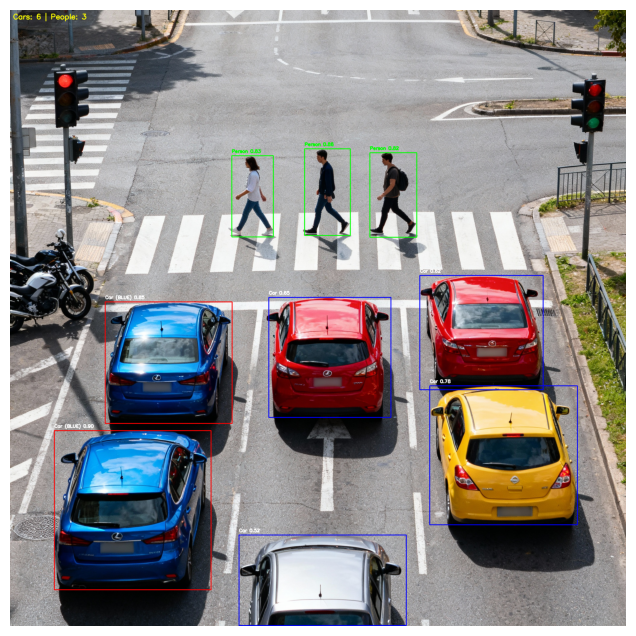

In [27]:
# Test on sample image
img = cv2.imread("sample7.png")  # replace with your image
annotated, counts = detect_and_annotate(img, model)

print("Counts:", counts)

# Show image in Jupyter (convert BGR → RGB)
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
